In [1]:
!nvidia-smi

Tue Dec 10 13:05:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off | 00000000:41:00.0 Off |                    0 |
| N/A   34C    P0              69W / 500W |   2330MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [20]:
!pip install torchinfo

Defaulting to user installation because normal site-packages is not writeable


In [14]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu121
     |████████████████████████████████| 3.4 MB 9.3 MB/s eta 0:00:01


### Import necessary modules

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b7
from torchvision.io import read_image
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Paths
image_folder = "data/ISIC_2019_Training_Input_Unzipped/ISIC_2019_Training_Input"  
metadata_csv = "ISIC_2019_Training_Metadata.csv"  
groundtruth_csv = "ISIC_2019_Training_GroundTruth.csv"  

### Load the metadata and perform required pre-processing

In [5]:
# Load Metadata and Ground Truth
metadata = pd.read_csv(metadata_csv)
groundtruth = pd.read_csv(groundtruth_csv)

In [6]:
# Combine one-hot encoded columns into a single label column (correct cancer type labels)
groundtruth["label"] = groundtruth[['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']].idxmax(axis=1)

In [7]:
print("Verifying label column:")
print(groundtruth[["image", "label"]].head())

Verifying label column:
          image label
0  ISIC_0000000    NV
1  ISIC_0000001    NV
2  ISIC_0000002   MEL
3  ISIC_0000003    NV
4  ISIC_0000004   MEL


In [8]:
data = groundtruth.merge(metadata, on="image", how="inner")

In [10]:
data["age_approx"].fillna(data["age_approx"].median(), inplace=True)
data["sex"].fillna("unknown", inplace=True)
data["anatom_site_general"].fillna("unknown", inplace=True)

# Correctly encode the cancer type labels
label_encoder = LabelEncoder()
data["encoded_label"] = label_encoder.fit_transform(data["label"])  # Encode the 'label' column
print(f"Cancer Type Label Mapping: {dict(enumerate(label_encoder.classes_))}")

# Encode other categorical features (e.g., sex and anatomical site) if necessary
data["encoded_sex"] = LabelEncoder().fit_transform(data["sex"])
data["encoded_anatom_site"] = LabelEncoder().fit_transform(data["anatom_site_general"])

Cancer Type Label Mapping: {0: 'AK', 1: 'BCC', 2: 'BKL', 3: 'DF', 4: 'MEL', 5: 'NV', 6: 'SCC', 7: 'VASC'}


In [11]:
scaler = StandardScaler()
data["normalized_age"] = scaler.fit_transform(data["age_approx"].values.reshape(-1, 1))

### Loading the images from the dataset

In [12]:
class SkinCancerDataset(Dataset):
    def __init__(self, data, image_folder, transform=None):
        self.data = data
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_folder, row["image"] + ".jpg")

        # Load image with PIL to handle transforms
        image = Image.open(image_path).convert("RGB")
        
        label = torch.tensor(row["encoded_label"]).long()
        additional_features = torch.tensor([row["normalized_age"], 
                                            row["encoded_sex"], 
                                            row["encoded_anatom_site"]]).float()

        if self.transform:
            image = self.transform(image)
        return image, additional_features, label

### Performing preprocessing on the images and splitting into train, test and validation datasets

In [13]:
# Image preprocessing
image_size = 380
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
# Split dataset
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data["encoded_label"], random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, stratify=test_data["encoded_label"], random_state=42)

# Create datasets
train_dataset = SkinCancerDataset(train_data, image_folder, transform)
val_dataset = SkinCancerDataset(val_data, image_folder, transform)
test_dataset = SkinCancerDataset(test_data, image_folder, transform)

# Data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


### Defining the model

The model is built on top of pre-trained EfficientNet-B7 model. This is used to preprocess the image data by extracting the visual features. The metadata (e.g., age, sex, anatomical site) is preprocessed through a separate feature extractor consisting of fully connected layers with ReLU activations. These two feature sets are concatenated into a unified representation, which is passed to a final classification layer to predict the output class.

In [15]:
class SkinCancerModel(nn.Module):
    def __init__(self, num_classes):
        super(SkinCancerModel, self).__init__()
        self.efficient_net = efficientnet_b7(pretrained=True)
        self.feature_extractor = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.classifier = nn.Linear(self.efficient_net.classifier[1].in_features + 16, num_classes)
        self.efficient_net.classifier = nn.Identity()

    def forward(self, x, features):
        img_features = self.efficient_net(x)
        additional_features = self.feature_extractor(features)
        combined_features = torch.cat((img_features, additional_features), dim=1)
        return self.classifier(combined_features)

# Instantiate the model
num_classes = len(data["encoded_label"].unique())
model = SkinCancerModel(num_classes).to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [17]:
# Display the labels being predicted
print("Labels being predicted:")
print(dict(enumerate(label_encoder.classes_)))

Labels being predicted:
{0: 'AK', 1: 'BCC', 2: 'BKL', 3: 'DF', 4: 'MEL', 5: 'NV', 6: 'SCC', 7: 'VASC'}


### Model Summary

In [12]:
from torchinfo import summary

# Ensure model is on GPU
model.to('cuda')

# Input dimensions
image_input_size = (3, 380, 380)  
feature_input_size = (3,)         

# Move inputs to GPU
image_input = torch.randn(1, *image_input_size).to('cuda')  
feature_input = torch.randn(1, *feature_input_size).to('cuda')  

# Print the model summary
summary(
    model,
    input_data=(image_input, feature_input),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    depth=3  # Adjust depth to control the level of details
)

Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Trainable
SkinCancerModel                                              [1, 3, 380, 380]          [1, 8]                    --                        True
├─EfficientNet: 1-1                                          [1, 3, 380, 380]          [1, 2560]                 --                        True
│    └─Sequential: 2-1                                       [1, 3, 380, 380]          [1, 2560, 12, 12]         --                        True
│    │    └─Conv2dNormActivation: 3-1                        [1, 3, 380, 380]          [1, 64, 190, 190]         1,856                     True
│    │    └─Sequential: 3-2                                  [1, 64, 190, 190]         [1, 32, 190, 190]         10,920                    True
│    │    └─Sequential: 3-3                                  [1, 32, 190, 190]         [1, 48, 95, 95]           253,424           

### Counting the number of layers

In [22]:
from collections import Counter

def count_layers(module, counter=Counter()):
    for child in module.children():
        counter[type(child)] += 1
        count_layers(child, counter)
    return counter

layer_counts = count_layers(model)
print(f"Total layers: {sum(layer_counts.values())}")

Total layers: 1109


### Training the model 

Implement the training loop with validation and early stopping, saving the best model based on validation loss.

In [18]:
def train_model(model, train_loader, val_loader, num_epochs=20, patience=5):
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, correct, total = 0, 0, 0

        for images, features, labels in train_loader:
            images, features, labels = images.to(device), features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss /= len(train_loader.dataset)
        train_acc = correct / total * 100

        # Validation phase
        model.eval()
        val_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for images, features, labels in val_loader:
                images, features, labels = images.to(device), features.to(device), labels.to(device)
                outputs = model(images, features)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = correct / total * 100

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_skin_cancer_model_b7_with_metadata.pth")
            print("Model saved!")
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        # Early stopping
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

# Train the model
train_model(model, train_loader, val_loader, num_epochs=20)

Epoch 1/20, Train Loss: 0.8297, Train Acc: 71.11%, Val Loss: 0.5920, Val Acc: 78.68%
Model saved!
Epoch 2/20, Train Loss: 0.5495, Train Acc: 80.21%, Val Loss: 0.5183, Val Acc: 81.96%
Model saved!
Epoch 3/20, Train Loss: 0.4001, Train Acc: 85.83%, Val Loss: 0.4336, Val Acc: 84.92%
Model saved!
Epoch 4/20, Train Loss: 0.2975, Train Acc: 89.32%, Val Loss: 0.4649, Val Acc: 84.17%
Epoch 5/20, Train Loss: 0.2281, Train Acc: 92.16%, Val Loss: 0.4459, Val Acc: 87.05%
Epoch 6/20, Train Loss: 0.1786, Train Acc: 93.69%, Val Loss: 0.4408, Val Acc: 86.38%
Epoch 7/20, Train Loss: 0.1439, Train Acc: 94.99%, Val Loss: 0.4982, Val Acc: 85.59%
Epoch 8/20, Train Loss: 0.1235, Train Acc: 95.63%, Val Loss: 0.4724, Val Acc: 87.01%
Early stopping triggered.


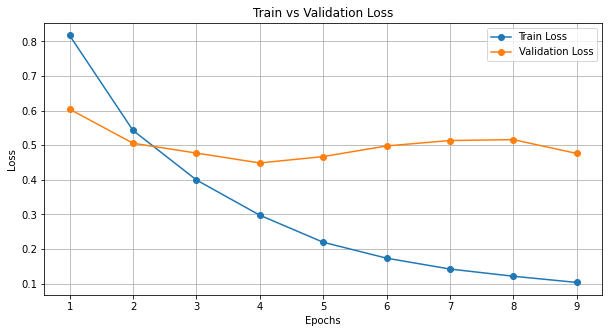

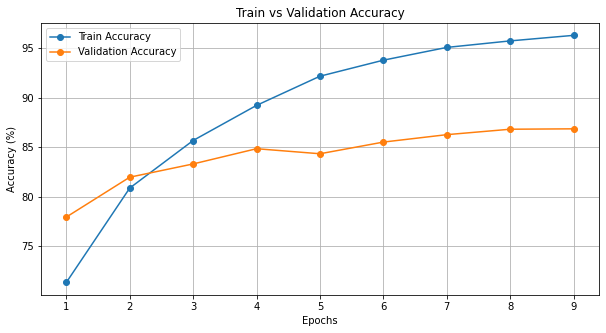

In [1]:
import matplotlib.pyplot as plt

# Data for plotting
epochs = list(range(1, 10))
train_loss = [0.8173, 0.5428, 0.3997, 0.2978, 0.2197, 0.1737, 0.1423, 0.1215, 0.1036]
val_loss = [0.6041, 0.5057, 0.4773, 0.4487, 0.4672, 0.4979, 0.5135, 0.5161, 0.4761]
train_acc = [71.32, 80.86, 85.67, 89.22, 92.17, 93.79, 95.08, 95.74, 96.30]
val_acc = [77.93, 81.96, 83.30, 84.84, 84.33, 85.51, 86.26, 86.81, 86.85]

# Plot Train vs Val Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Train vs Val Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

We can see that there is **NO OVERFITTING**

### Performance Evaluation of the Model

Test Accuracy: 84.29%


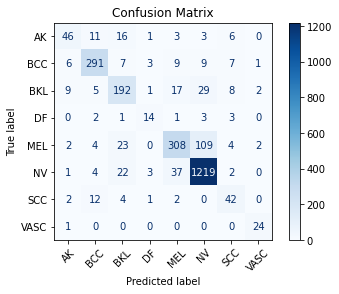

In [19]:
def evaluate_model(model, test_loader):
    # Load the model
    model.load_state_dict(torch.load("best_skin_cancer_model_b7_with_metadata.pth"))
    model.to(device)
    model.eval()
    correct, total = 0, 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, features, labels in test_loader:
            images, features, labels = images.to(device), features.to(device), labels.to(device)
            outputs = model(images, features)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"Test Accuracy: {correct / total * 100:.2f}%")

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_loader)

The multi-label skin cancer classification model has an accuracy of **84.29%** for classifying 9 classes.

### Visualizing Model Predictions

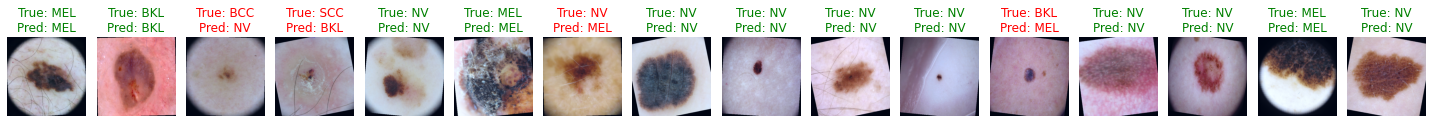

In [20]:
# Check predictions visually
def visualize_predictions(model, test_loader):
    model.eval()
    test_iter = iter(test_loader)
    images, metadata, labels = next(test_iter)

    images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images, metadata)
        _, preds = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    label_mapping = {idx: label for idx, label in enumerate(label_encoder.classes_)}

    for i, ax in enumerate(axes):
        image = images[i].permute(1, 2, 0).cpu().numpy()
        image = (image * 0.229) + 0.485  # De-normalize
        image = np.clip(image, 0, 1)

        true_label = label_mapping[labels[i].item()]
        pred_label = label_mapping[preds[i].item()]

        color = "green" if true_label == pred_label else "red"
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color)
        ax.imshow(image)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader)